In [18]:
import numpy as np
np.random.seed(1) # for reproducibility

import keras.backend as K
import tensorflow as tf
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import pickle
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import optimizers
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
import statsmodels.api as sm

data = sm.datasets.co2.load_pandas().data
data.dropna(inplace=True)
print(data.head())
# CO2 Emissions Dataset: Daily CO2 measurements from Mauna Loa Observatory.
# Or get 'macrodata' for macroeconomic time series data
# data_macro = sm.datasets.macrodata.load_pandas().data
# print(data_macro.head())

              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4


In [20]:
data.describe()

,co2
count,2225.000000
mean,340.142247
std,17.003885
min,313.000000
25%,324.800000
50%,338.300000
75%,354.800000
max,373.900000


In [21]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = data_scaled.reshape(data_scaled.shape[0])

In [22]:
data_scaled.shape

(2225,)

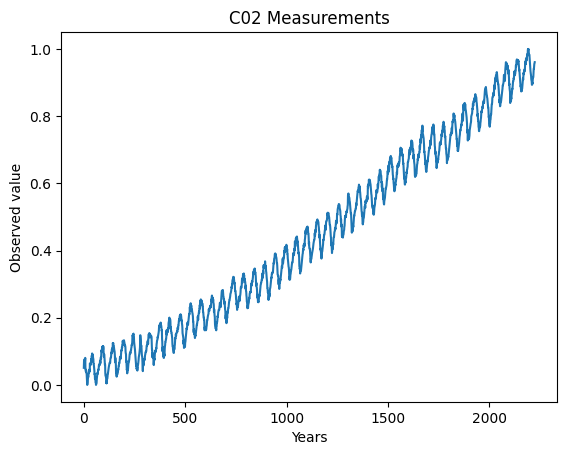

In [23]:
plt.title('C02 Measurements')
plt.xlabel('Years')
plt.ylabel('Observed value')
plt.plot(data_scaled)

In [24]:
def create_data(dataset,window_size = 10):
    # df = dataset.to_numpy()
    df = dataset.copy()
    X = []
    y = []
    for i in range(len(df)-window_size):
        row = [a for a in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append(label)
        
    return np.array(X),np.array(y)



In [25]:
WINDOW_SIZE = 10

X,y = create_data(data_scaled,WINDOW_SIZE)

In [26]:
y.shape

(2215,)

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [28]:
model_mse = Sequential()
model_mse.add(InputLayer(shape = (10,1)))
# model_mse.add(LSTM(64))
model_mse.add(GRU(128))
model_mse.add(Dense(8,'relu'))
model_mse.add(Dense(1,'linear'))

# model_mse.summary()
model_mse.compile(loss='mse',optimizer=Adam(learning_rate=0.0001),metrics = [RootMeanSquaredError()])
history_mse = model_mse.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1941 - root_mean_squared_error: 0.4391 - val_loss: 0.0580 - val_root_mean_squared_error: 0.2409
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - root_mean_squared_error: 0.1822 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0699
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 6.4634e-04 - val_root_mean_squared_error: 0.0254
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5

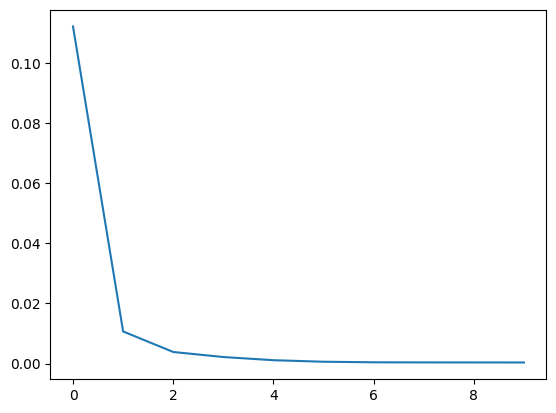

In [29]:
plt.plot(history.history['loss'])

In [30]:
import tensorflow as tf
import keras.backend as K
def custom_loss(y_true, y_pred):
    # Extract "next day's price" and "today's price"
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    # Calculate the up/down movement (direction) for both y_true and y_pred
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
    
    # Compare movements: if the difference is positive, it's an "UP" (1), else "DOWN" (0)
    y_true_move = tf.cast(tf.greater_equal(y_true_diff, 0), tf.float32)
    y_pred_move = tf.cast(tf.greater_equal(y_pred_diff, 0), tf.float32)
    
    # Find positions where predicted direction does not match the true direction
    direction_mismatch = tf.not_equal(y_true_move, y_pred_move)
    
    # Apply a penalty for mismatches, use tf.where to conditionally apply penalty
    penalty_factor = tf.reduce_mean(tf.abs(y_true_diff)) 
    penalty = tf.where(direction_mismatch, 
                       (tf.abs(y_true_diff - y_pred_diff) * penalty_factor), 
                       tf.zeros_like(y_true_diff))   
    # Mean squared error loss
    # mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    
    # Combine the MSE loss with the directional penalty
    custom_loss = mse_loss + penalty
    
    return custom_loss




In [31]:
model_mae = Sequential()
model_mae.add(InputLayer(shape = (10,1)))
model_mae.add(LSTM(64))
model_mae.add(Dense(8,'relu'))
model_mae.add(Dense(1,'linear'))

# model_mae.summary()
# cp = model_maeCheckpoint('output/best_model.weights.h5',save_weights_only=False)
# cp = model_maeCheckpoint('output/best_model.keras',save_weights_only=False)
model_mae.compile(loss='mse',optimizer=Adam(learning_rate=0.0001),metrics = [RootMeanSquaredError()])
history_mae = model_mae.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1416 - root_mean_squared_error: 0.3752 - val_loss: 0.0504 - val_root_mean_squared_error: 0.2245
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347 - root_mean_squared_error: 0.1840 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0665
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1186

In [32]:
model_custom = Sequential()
model_custom.add(InputLayer(shape = (10,1)))
model_custom.add(LSTM(64))
model_custom.add(Dense(8,'relu'))
model_custom.add(Dense(1,'linear'))

model_custom.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.0001),metrics = [RootMeanSquaredError()])
# model_custom.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.0001),metrics = ['accuracy'])

history_custom = model_custom.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1414 - root_mean_squared_error: 0.3736 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1653
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - root_mean_squared_error: 0.1151 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0549
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0494 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0437
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0397 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0351
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0340 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0297
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0279 - val_loss: 9.9578e-04 - val_root_mean_squared_error: 0.0266
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

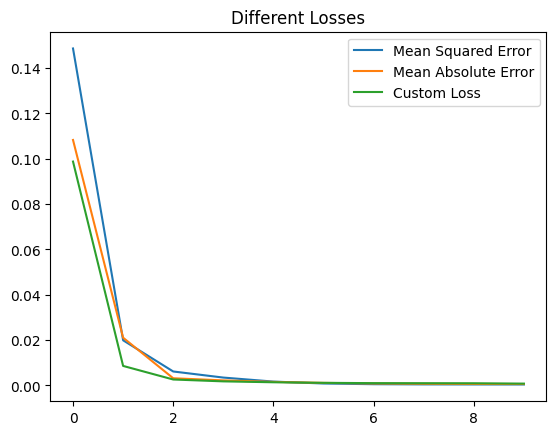

In [33]:
plt.plot(history_mse.history['loss'],label = 'Mean Squared Error')
plt.plot(history_mae.history['loss'],label = 'Mean Absolute Error')
plt.plot(history_custom.history['loss'],label = 'Custom Loss')
plt.title('Different Losses')
plt.legend()
plt.show()

In [34]:
train_predictions_custom_val = model_custom.predict(X_test).flatten()
train_predictions = model_mse.predict(X_test).flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [35]:
from sklearn.metrics import r2_score,mean_absolute_error

print(r2_score(train_predictions_custom_val,train_predictions))

0.9995076656341553
